In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [3]:
# ------------------------------------------------------------------------------
# Load the datasets
# Adjust the paths as necessary for your environment.
df_fake = pd.read_csv("data/fake_with_metadata.csv")
df_real = pd.read_csv("data/real_with_metadata.csv")  

# ------------------------------------------------------------------------------
# Add labels (assuming: 0 for fake and 1 for real)
df_fake["labels"] = 0
df_real["labels"] = 1

# Combine into one DataFrame
data = pd.concat([df_fake, df_real], ignore_index=True)

# ------------------------------------------------------------------------------
# Fill missing values for the relevant columns
for col in ['news_url', 'title', 'meta_title', 'meta_description', 'combined_text']:
    data[col] = data[col].fillna("")

In [4]:
# ------------------------------------------------------------------------------
# Experiment 1: Title-Only Model
# ------------------------------------------------------------------------------
print("----- Experiment 1: Title-Only Model -----\n")

X_title = data[['title']]
y = data['labels']

# Split into training and testing sets
X_train_title, X_test_title, y_train, y_test = train_test_split(
    X_title, y, test_size=0.2, random_state=42
)

# Vectorize titles using TF-IDF
tfidf_title = TfidfVectorizer(max_features=5000)
X_train_title_features = tfidf_title.fit_transform(X_train_title['title']).toarray()
X_test_title_features  = tfidf_title.transform(X_test_title['title']).toarray()

# Train and evaluate classifier using title-only features
model_title = RandomForestClassifier(random_state=42)
model_title.fit(X_train_title_features, y_train)
y_pred_title = model_title.predict(X_test_title_features)

print("Title-Only Features Performance:")
print(classification_report(y_test, y_pred_title))


# ------------------------------------------------------------------------------
# Define a helper function to extract URL features
# This is just an example; adapt as needed.
def extract_url_features(url):
    if pd.isna(url) or url == "":
        return [0, 0, 0]
    # Example features: URL length, count of "/" characters, count of "?" characters.
    length = len(url)
    count_slashes = url.count('/')
    count_params = url.count('?')
    return [length, count_slashes, count_params]

----- Experiment 1: Title-Only Model -----

Title-Only Features Performance:
              precision    recall  f1-score   support

           0       0.76      0.46      0.58      1164
           1       0.84      0.95      0.89      3521

    accuracy                           0.83      4685
   macro avg       0.80      0.71      0.74      4685
weighted avg       0.82      0.83      0.82      4685



In [5]:
# ------------------------------------------------------------------------------
# Experiment 2: URL-Only Model
# ------------------------------------------------------------------------------
print("\n----- Experiment 2: URL-Only Model -----\n")

X_url = data['news_url']

# Split the URL data
X_train_url, X_test_url, y_train, y_test = train_test_split(
    X_url, y, test_size=0.2, random_state=42
)

# Extract URL features for each sample in the train and test splits
train_url_features = pd.DataFrame([extract_url_features(url) for url in X_train_url])
test_url_features  = pd.DataFrame([extract_url_features(url) for url in X_test_url])

# Scale URL features
scaler_url = StandardScaler()
train_url_features_scaled = scaler_url.fit_transform(train_url_features)
test_url_features_scaled  = scaler_url.transform(test_url_features)

# Train and evaluate classifier using URL-only features
model_url = RandomForestClassifier(random_state=42)
model_url.fit(train_url_features_scaled, y_train)
y_pred_url = model_url.predict(test_url_features_scaled)

print("URL-Only Features Performance:")
print(classification_report(y_test, y_pred_url))


----- Experiment 2: URL-Only Model -----

URL-Only Features Performance:
              precision    recall  f1-score   support

           0       0.73      0.52      0.61      1164
           1       0.86      0.94      0.89      3521

    accuracy                           0.83      4685
   macro avg       0.79      0.73      0.75      4685
weighted avg       0.82      0.83      0.82      4685



In [6]:
# ------------------------------------------------------------------------------
# Experiment 3: All-Metadata Model (Text + URL Features)
# ------------------------------------------------------------------------------
print("\n----- Experiment 3: All-Metadata (Text + URL) Model -----\n")

# Combine the relevant text fields into a single string.
def combine_text(row):
    texts = [
        str(row['title']),
        str(row['meta_title']),
        str(row['meta_description']),
        str(row['combined_text'])
    ]
    return " ".join(texts)

data['all_text'] = data.apply(combine_text, axis=1)

# Prepare features using both all_text and news_url
X_all = data[['all_text', 'news_url']]
y_all = data['labels']

# Split combined data into training and test sets.
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

# ---------- Text Features ----------
tfidf_all = TfidfVectorizer(max_features=5000)
X_train_text_features = tfidf_all.fit_transform(X_train_all['all_text']).toarray()
X_test_text_features  = tfidf_all.transform(X_test_all['all_text']).toarray()

# ---------- URL Features ----------
train_url_features_all = pd.DataFrame([
    extract_url_features(url) for url in X_train_all['news_url']
])
test_url_features_all = pd.DataFrame([
    extract_url_features(url) for url in X_test_all['news_url']
])

scaler_all = StandardScaler()
train_url_features_all_scaled = scaler_all.fit_transform(train_url_features_all)
test_url_features_all_scaled  = scaler_all.transform(test_url_features_all)

# ---------- Combine Text and URL Features ----------
X_train_combined = np.hstack((X_train_text_features, train_url_features_all_scaled))
X_test_combined  = np.hstack((X_test_text_features, test_url_features_all_scaled))

# Train and evaluate classifier on the combined feature set.
model_combined = RandomForestClassifier(random_state=42)
model_combined.fit(X_train_combined, y_train_all)
y_pred_combined = model_combined.predict(X_test_combined)

print("All-Metadata (Text + URL) Features Performance:")
print(classification_report(y_test_all, y_pred_combined))


----- Experiment 3: All-Metadata (Text + URL) Model -----

All-Metadata (Text + URL) Features Performance:
              precision    recall  f1-score   support

           0       0.89      0.66      0.76      1164
           1       0.90      0.97      0.93      3521

    accuracy                           0.90      4685
   macro avg       0.90      0.82      0.85      4685
weighted avg       0.90      0.90      0.89      4685



In [7]:
from sklearn.metrics import classification_report

# Get the classification reports as dictionaries for each model
title_report = classification_report(y_test, y_pred_title, output_dict=True)
url_report = classification_report(y_test, y_pred_url, output_dict=True)
combined_report = classification_report(y_test_all, y_pred_combined, output_dict=True)


In [8]:
# Metrics extraction: accuracy and macro-average f1-score
accuracy = {
    "Title-Only": title_report["accuracy"],
    "URL-Only": url_report["accuracy"],
    "All-Metadata": combined_report["accuracy"]
}

f1_macro = {
    "Title-Only": title_report["macro avg"]["f1-score"],
    "URL-Only": url_report["macro avg"]["f1-score"],
    "All-Metadata": combined_report["macro avg"]["f1-score"]
}


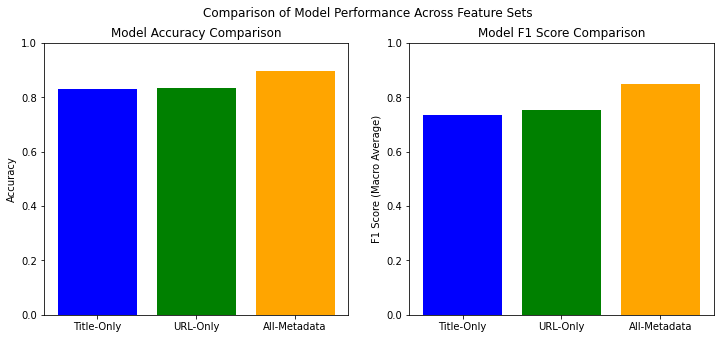

In [9]:
import matplotlib.pyplot as plt

# Create subplots to compare Accuracy and F1 Score
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy bar plot
ax[0].bar(accuracy.keys(), accuracy.values(), color=['blue', 'green', 'orange'])
ax[0].set_ylim(0, 1)
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Model Accuracy Comparison")

# F1 Score bar plot
ax[1].bar(f1_macro.keys(), f1_macro.values(), color=['blue', 'green', 'orange'])
ax[1].set_ylim(0, 1)
ax[1].set_ylabel("F1 Score (Macro Average)")
ax[1].set_title("Model F1 Score Comparison")

plt.suptitle("Comparison of Model Performance Across Feature Sets")
plt.show()


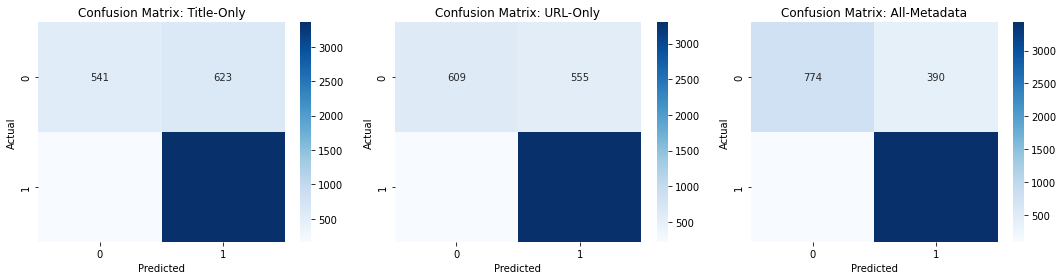

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_title = confusion_matrix(y_test, y_pred_title)
cm_url = confusion_matrix(y_test, y_pred_url)
cm_combined = confusion_matrix(y_test_all, y_pred_combined)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, cm, title in zip(axes, [cm_title, cm_url, cm_combined],
                           ["Title-Only", "URL-Only", "All-Metadata"]):
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues")
    ax.set_title(f"Confusion Matrix: {title}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
